In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

import requests
import math
import random
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
from wordcloud import STOPWORDS
from scipy.sparse import csr_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kanga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kanga\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<font color=#cccccc>6조. MID_PR (영화 리뷰 데이터 : 감성분류 & 긍정/부정 키워드 분석)</font>
==

 # <font color=#cccccc>데이터 수집</font>
 - 
    - 감성분류를 위한 텍스트 영화리뷰 데이터(네이버영화)<br><br>
    - 평점 / 리뷰 데이터를 수집하여 평점이 낮은 리뷰에 부정적 단어와 높은점수의 리뷰에서 긍정단어를 추출

### <font color=blue>WebScraping</font>

In [5]:
url = "https://movie.naver.com/movie/point/af/list.nhn?&page="
headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}
movie_list = []
numb_list = []
score_list = []
comment_list = []
for page in range(1,1001):
    web = requests.get(url+str(page), headers = headers).content
    soup = BeautifulSoup( web, 'html.parser')
    numb = soup.find_all('td', {"class":"ac num"})
    
#     movie_title = td.select_one('a.movie').text.strip()
#     score = td.select_one('div.list_netizen_score > em').text.strip()
#     comment = td.select_one('br').next_sibling.strip()
    
    for numb in numb:
        numb_list.append(numb.text)
    movie_name_lst = soup.find_all('a', {"class":"movie color_b"})
    for movie_name in movie_name_lst:
        movie_list.append(movie_name.text)
    star_score_lst = soup.find_all('div',{'class':"list_netizen_score"})
    for star_score in star_score_lst:
        score_list.append(star_score.find('em').text)
    comment_lst = soup.find_all('td', {'class':"title"})
    for comment in comment_lst:
        comment_list.append(comment.select_one('br').next_sibling.strip())      

### <font color=blue>Crawling</font>

In [ ]:
# # Crawling 방법 2
# url = "https://movie.naver.com/movie/point/af/list.nhn?&page="
# headers = {'User-Agent' : 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.101 Safari/537.36'}

# movie_list = []
# numb_list = []
# score_list = []
# comment_list = []


## Tag 꺼내기
# for page in range(1,1001):
#     web = requests.get(url+str(page), headers = headers).content
#     soup = BeautifulSoup( web, 'html.parser')
    
#     numb = soup.find_all('td', {"class":"ac num"})
#     for numb in numb:
#         numb_list.append(numb.text)
        
#     movie_name_lst = soup.find_all('a', {"class":"movie color_b"})
#     for movie_name in movie_name_lst:
#         movie_list.append(movie_name.text)
    
#     star_score_lst = soup.find_all('div',{'class':"list_netizen_score"})
#     for star_score in star_score_lst:
#         score_list.append(star_score.find('em').text)
        
#     comment_lst = soup.find_all('td', {'class':"title"})
#     for comment in comment_lst:

#         # br class 다음 문자열을 불러옴. next_sibling
#         comment_list.append(comment.select_one('br').next_sibling.strip())
    
#     interval = round(random.uniform(0.2, 1.2),2)
#     time.sleep(interval)

# # list로 받아진 데이터들을 zip함수를 이용해 합치고, column 명을 넣어준다.
# df = pd.DataFrame([ x for x in zip(numb_list, movie_list, score_list, comment_list)], columns=['리뷰번호','영화명','평점','리뷰'])

In [6]:
df_movie_list   = pd.DataFrame(movie_list, columns   = ['title'])
df_numb_list    = pd.DataFrame(numb_list, columns    = ['number'])
df_score_list   = pd.DataFrame(score_list, columns   = ['score'])
df_comment_list = pd.DataFrame(comment_list, columns = ['text'])

In [7]:
df_final = pd.concat([df_movie_list,df_numb_list,df_score_list,df_comment_list], axis=1)
df_final.to_csv('naver_movie.csv', encoding='utf-8', index=False)

In [8]:
df = pd.read_csv('naver_movie.csv', encoding='utf-8')
df.head()

,title,number,score,text


 # <font color=#cccccc>data exploration</font>

### <font color=blue>결측치 확인 / information</font>

In [3]:
print('###################결측치#######################')
print(df.isnull().sum())
print('---------------------------------------------')
print('#################데이터정보#####################')
print(df.info())

###################결측치#######################
title       0
number      0
score       0
text      533
dtype: int64
---------------------------------------------
#################데이터정보#####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
title     10000 non-null object
number    10000 non-null int64
score     10000 non-null int64
text      9467 non-null object
dtypes: int64(2), object(2)
memory usage: 312.6+ KB
None


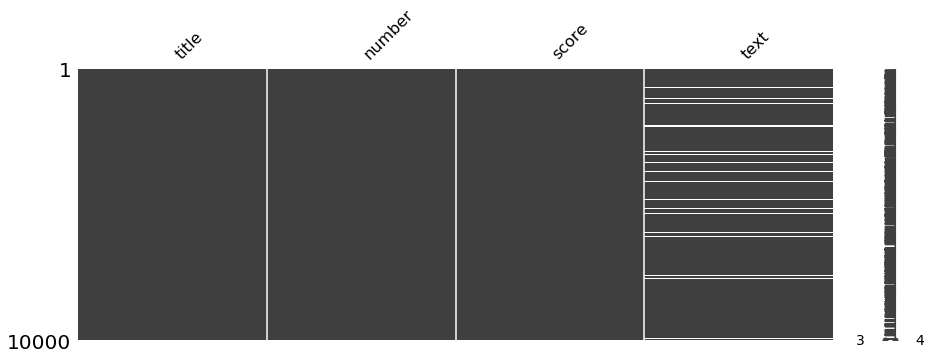

In [4]:
msno.matrix(df, figsize=(15,5))

In [5]:
# drop된 row를 제거하고, re indexing
df.dropna(axis = 0, inplace=True)
df.reset_index(inplace=True)
del df['index']

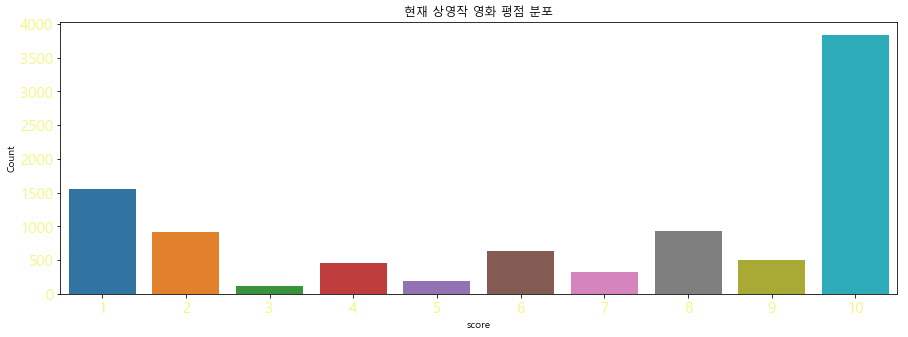

In [6]:
font_name = matplotlib.font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name() # NanumGothic.otf
matplotlib.rc('font', family=font_name)
plt.rc('font')

count=df['score'].value_counts()

plt.figure(figsize=(15,5))
plt.xticks(color='#F3F781', fontsize =15) 
plt.yticks(color='#F3F781', fontsize =15)
sns.barplot(count.index,count)
plt.title("현재 상영작 영화 평점 분포")
plt.xlabel('score')
plt.ylabel('Count')
plt.show()

 # <font color=#cccccc>한글 텍스트 전처리</font>

### <font color=blue>정규표현식 함수를 정의</font>

In [7]:
def apply_regular_expression(text):
    hangul = re.compile('[^ ㄱ-ㅣ 가-힣]')  # 한글 추출 규칙: 띄어 쓰기(1 개)를 포함한 한글
    result = hangul.sub('', text)  # 위에 설정한 "hangul"규칙을 "text"에 적용(.sub)시킴
    return result

In [8]:
apply_regular_expression(df['text'][0])

'편보다 재밌고 편이 기대되는 편'

### <font color=blue>Konlpy라이브러리의 Okt객체를 통한 명사 형태소 추출</font>

In [9]:
okt = Okt()  # 명사 형태소 추출 함수
nouns = okt.nouns(apply_regular_expression(df['text'][0]))
nouns

['편', '편이', '기대', '편']

### <font color=blue>말 뭉치 생성 / 정규표현식 적용</font>

In [10]:
corpus = "".join(df['text'].tolist())
corpus[:100]

'1편보다 재밌고 3편이 기대되는 2편엄청 재밌어요! 후회 절대 안하실 겁니다! 너무 재밌어서 자막없이 한 번 더 보려고 합니다. 꼭 보세오 후회 안합니다!!그리스 배경에 청량한 느'

In [11]:
# 정규 표현식 적용
corpus_accept = apply_regular_expression(corpus)
print(corpus_accept[:1000])

편보다 재밌고 편이 기대되는 편엄청 재밌어요 후회 절대 안하실 겁니다 너무 재밌어서 자막없이 한 번 더 보려고 합니다 꼭 보세오 후회 안합니다그리스 배경에 청량한 느낌 항상 웃고 있는 배우분들의 표정 중독성 강한 까지 정말 작품성이 높은 탄탄한 스토리는 아니지만 행복해지고 싶을 때 보는 인생 영화배우가 ㅈ같네손영주 배우의 연기가 참 좋네요 추천합니다역시 실망시키지 않았음가 너무 강렬해서 들을때마다 가슴이 괜히 뭉클해져잔인하네 쏘우 전작을 안봐서 다행 일단 그것밖에는인간의 탐욕과 이기심을 적나라하게 드러낸 명작그냥 한국영화 그 자체 조우진 연기는 볼만했음보는내내 긴장감 있었어요진기주 위하준 연기대박마지막 말이 압권이었음자신이 어떻게 죽을지 몰라야 인생을 사는게 재밌다는게원작 그대로 따라하고 ㅎ삼성차는 터지고 제네시스는 이쁘게나옴 ㅋ조우진 연기는 딱여기까지인듯발암전개가 안타깝지만 편을 위한 숨고르기라 믿고 싶다개인적으로 너무 좋았습니다왜 평점은 마이너스가 없나요배우들은 대단한거같아요 어떤상황이든 감정이입을 해야하니까ㅠㅠ 이런 ㅈ같은장르의 영화에서도최선을다한 배우들에겐 높이평가합니다한국이아니라 타이완이나ㅠ베트남쪽 사람들데리고 영화만드셧음ㅜ좋겟어요배우들 연기나 연출모두 좋았고 사람마다 와닿는 바가 다르겠지만 나한텐 개인적으로 울림이있는 영화였다고 생각한다 단순히 하니 연기가 궁금해서 봤는데 괜히 먹먹하고 복잡한 생각이 드는편의적인 플래시백이 서사에 걸림돌만 된다전력으로 손을 뻗을 수 밖에 없는 간절함인간의 교감은 말로 설명할 수 없는 것 같다그게 어떤 관계이든간에 재밌다 원빈 얼굴도내용도여고생 연기잘함 개소름시간가는줄 모르고 봤습니다명작 추격자도 답답혀 개연성 따지지 말어년 영화라니 개봉할 때 봤을 때보다 훨씬 다층적으로 생각하고 느낄 수 있었다 와의 사랑이 납득되는 걸 보니 다양성에 관한 영화이기도 하고 당연히 사랑과 관계에 관한 영화이기도 하고 성장에 관한 영화이기도 하다 미술 디자인이 다시 봐도 곱고밤인지 새벽인지 경계가 모호한 도심의 시간과 공간 표현도 좋다그

#### <font color=blue>POS Tagging</font>

In [12]:
raw_pos_tagged = okt.pos(corpus, norm=True, stem=True) # POS Tagging, norm=True:정규화(이영화 재미나욬ㅋㅋㅋㅋ -- > 이영화 재미나요), stem=True:어근
pd.DataFrame(raw_pos_tagged).tail(20)

,0,1
213108,있다,Adjective
213109,6,Number
213110,점,Noun
213111,초과,Noun
213112,하다,Verb
213113,주기,Noun
213114,는,Josa
213115,어렵다,Adjective
213116,보임,Noun
213117,.,Punctuation


 # <font color=#cccccc>불용어사전 정의 / 단어 빈도수 확인</font>

### <font color=blue>초기 단어 빈도수 확인</font>

In [16]:
# 빈도 탐색
from collections import Counter

counter_all_comment = Counter(raw_pos_tagged)
most_common = pd.DataFrame(counter_all_comment.most_common(10))
most_common

,0,1
0,"(., Punctuation)",6729
1,"(하다, Verb)",4855
2,"(이, Josa)",4329
3,"(영화, Noun)",4249
4,"(보다, Verb)",3923
5,"(가, Josa)",2875
6,"(에, Josa)",2817
7,"(의, Josa)",2570
8,"(을, Josa)",2442
9,"(들, Suffix)",2235


In [14]:
# set 함수를 사용하여 raw_pos_tagged pos값을 가져오고 중복은 제거한 순수한 pos값을 남긴다.
set_of_tag = set()
for tag in raw_pos_tagged:
    set_of_tag.add(tag[1])
print(set_of_tag)

{'PreEomi', 'Josa', 'Conjunction', 'URL', 'Punctuation', 'KoreanParticle', 'Modifier', 'Foreign', 'Hashtag', 'Adjective', 'Adverb', 'Exclamation', 'Eomi', 'Alpha', 'VerbPrefix', 'Noun', 'Suffix', 'Number', 'Determiner', 'Verb'}


### <font color=blue>불용어 사전 정의</font>

In [17]:
# 링크의 불용어 사전에, 현재데이터에서 빈도수가 높지만 감정과 관련없는 단어도 추가하여 불용어 사전을 정의 한다.
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stop_words = set([x[0] for x in stopwords])
movie_words = {'하다', '보다','있다','없다','너무','이다','영화',
           '되다','않다','같다','만들다','그냥','보고','정말',
           '가다','들다','진짜','싶다','정도','오다','많다',
           '연기','배우','그리고','부분','나다','편이','분들',
            '작품','영화','아니다','되는','겁니다','감독','합니다','싶을','같네'}
stop_words = stop_words.union(movie_words)

In [ ]:
# li = list([[1,2,3],[4,5,6]])
# sum(li,[])

In [18]:
# 반복 시행을 통해 추가 불용어에 pos tagging 한다.

word_cleaned = []

for word in raw_pos_tagged:
    if word[1] not in ["Josa", "Eomi", "Punctuation", "Foreign", "Number", "Hashtag", "URL","PreEomi"]: 
        if (len(word[0]) != 1) & (word[0] not in stop_words):
            word_cleaned.append(word[0])
        else :
            stop_words.add(word[0])
        
stop_words_lst = list(stop_words)
word_cleaned[:10]

['재밌다', '기대', '엄청', '재밌다', '후회', '절대', '재밌다', '자막', '없이', '후회']

In [19]:
result = Counter(word_cleaned)
word_dic = dict(result)
word_dic

{'재밌다': 1050,
 '기대': 196,
 '엄청': 82,
 '후회': 52,
 '절대': 70,
 '자막': 24,
 '없이': 229,
 '그리스': 1,
 '배경': 45,
 '청량하다': 5,
 '느낌': 359,
 '항상': 23,
 '웃다': 73,
 '표정': 36,
 '중독': 6,
 '강하다': 30,
 'Ost': 3,
 '높다': 99,
 '탄탄하다': 50,
 '스토리': 1009,
 '행복하다': 40,
 '인생': 178,
 '영화배우': 6,
 '손영주': 1,
 '차다': 153,
 '좋다': 1509,
 '추천': 178,
 '역시': 143,
 '실망': 62,
 'OST': 39,
 '강렬하다': 12,
 '가슴': 85,
 '괜히': 24,
 '뭉클하다': 16,
 '잔인하다': 38,
 '쏘우': 1,
 '전작': 29,
 '다행': 29,
 '그것': 56,
 '인간': 88,
 '탐욕': 2,
 '이기심': 2,
 '적나라하다': 5,
 '드러내다': 12,
 '명작': 95,
 '한국영': 63,
 '자체': 122,
 '조우진': 205,
 '긴장감': 240,
 '진기': 142,
 '대박': 101,
 '마지막': 293,
 '어떻다': 181,
 '죽다': 105,
 '모르다': 417,
 '살다': 138,
 '원작': 43,
 '그대로': 47,
 '따르다': 36,
 '삼성': 1,
 '터지다': 51,
 '제네시스': 76,
 '이쁘다': 81,
 '딱이다': 8,
 '발암': 70,
 '전개': 191,
 '안타깝다': 69,
 '고르다': 20,
 '기르다': 9,
 '믿다': 136,
 '개인': 109,
 '평점': 408,
 '마이너스': 6,
 '대단하다': 76,
 '상황': 99,
 '감정이입': 10,
 'ㅠㅠ': 240,
 '이렇다': 355,
 '장르': 80,
 '최선': 6,
 '다한': 12,
 '높이': 8,
 '평가': 43,
 '한국': 160,
 '타이완': 2,


In [20]:
# 출연빈도수가 높은 단어들로 내림차순하여 빈도수 top10을 확인한다.
sorted_word_dic = sorted(word_dic.items(), key=lambda x:x[1], reverse=True)
sorted_word_dic[:10]

[('좋다', 1509),
 ('재밌다', 1050),
 ('스토리', 1009),
 ('생각', 674),
 ('나오다', 615),
 ('자다', 554),
 ('연출', 511),
 ('사람', 504),
 ('모르다', 417),
 ('평점', 408)]

### <font color=blue>단어출연빈도 시각화</font>

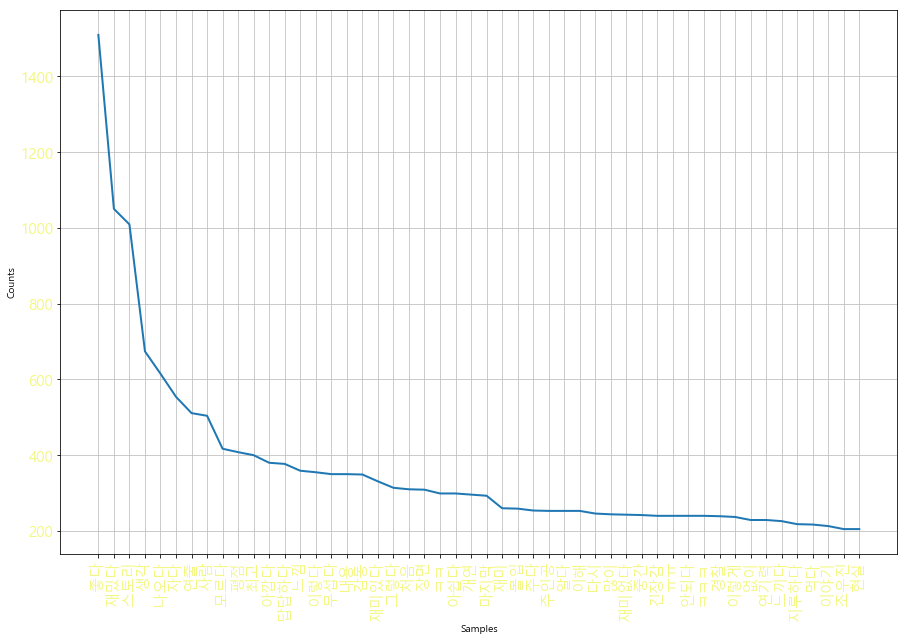

In [21]:
word_counted = nltk.Text(word_cleaned) 
plt.figure(figsize=(15, 10))
plt.rc('font')
#plt.gca().set_facecolor('black') #배경색
plt.xticks(color='#F3F781', fontsize =15) 
plt.yticks(color='#F3F781', fontsize =15) 
word_counted.plot(50)

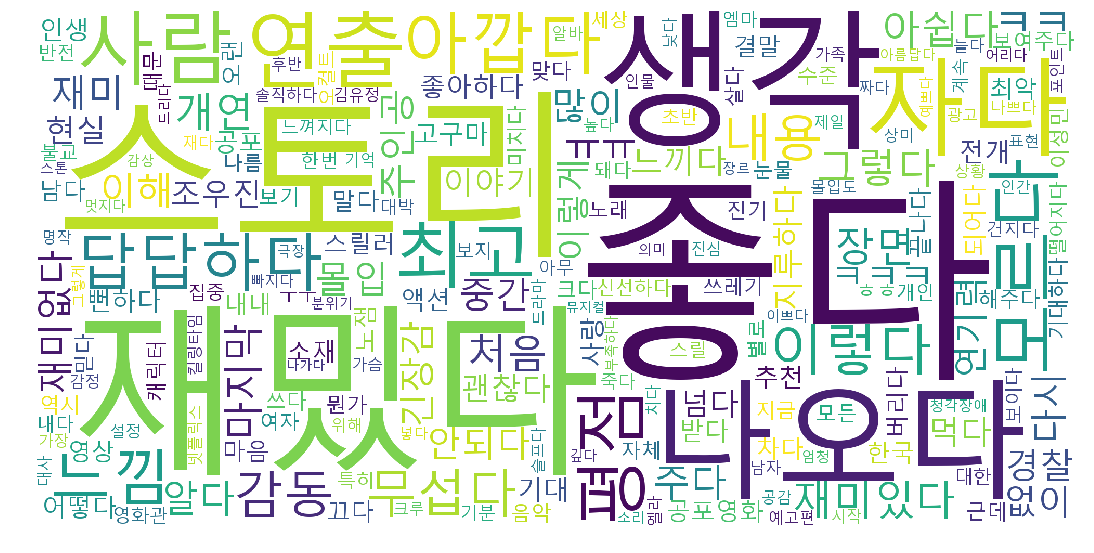

In [22]:
word_cloud = WordCloud(font_path="C:/Windows/Fonts/malgun.ttf",
                       width=2000, height=1000, 
                       background_color='white')
word_cloud.generate_from_frequencies(word_dic)

plt.figure(figsize=(15,15))
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

 # <font color=#cccccc>Feature Vectorizer 적용 / 단어 빈도수 확인</font>

### <font color=blue>Counter Vectorizer</font>

In [23]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [24]:
def text_cleaning(text):
    hangul = re.compile('[^ a-z A-Z ㄱ-ㅣ 가-힣]')  # 정규 표현식 처리
    result = hangul.sub('', text)
    okt = Okt()  # 형태소 추출
    words = okt.morphs(result)
    words = [x for x in words if len(x) > 1]  # 한글자 키워드 제거
    words = [x for x in words if x not in stop_words_lst]  # 불용어 제거
    return words

vect = CountVectorizer(tokenizer = lambda x: text_cleaning(x))
bow_vect = vect.fit_transform(df['text'].tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

### <font color=blue>Counter Vectorizer 적용결과</font>

In [25]:
# 단어 리스트
pd.DataFrame(word_list).tail(50)

,0
22876,힘드
22877,힘드네
22878,힘드셨나
22879,힘드셨을듯
22880,힘드시다는
22881,힘드실
22882,힘든
22883,힘든가를
22884,힘든거구나
22885,힘든데


In [26]:
# 각 단어가 전체 리뷰중에 등장한 총 횟수
pd.DataFrame(count_list[:10])

,0
0,1
1,1
2,2
3,8
4,2
5,1
6,1
7,1
8,2
9,1


In [27]:
# 각 단어의 자신의 리뷰의 등장 횟수
pd.DataFrame(bow_vect.toarray()[:10])

,0,1,2,3,4,5,6,7,8,9,...,22916,22917,22918,22919,22920,22921,22922,22923,22924,22925
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
bow_vect.shape

(9467, 22926)

In [29]:
# "단어" - "총 등장 횟수" Matching

#zip() 함수는 여러 개의 순회 가능한(iterable) 객체를 인자로 받고, 
#각 객체가 담고 있는 원소를 튜플의 형태로 차례로 접근할 수 있는 반복자(iterator)를 반환한다.

word_count_dict = dict(zip(word_list, count_list))
word_Freq = pd.DataFrame(word_count_dict.items())
word_Freq.tail(20)

,0,1
22906,힘들었으나,2
22907,힘들었을,1
22908,힘들었을듯,1
22909,힘들었을지,1
22910,힘들었을텐데,1
22911,힘들었지만,1
22912,힘들지만,2
22913,힘들텐데,3
22914,힘듦,2
22915,힘듬,2


### <font color=blue>Tf-Idf Vectorizer 객체 생성 / 적용</font>

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfTransformer()
tf_idf_vect = tfidf_vectorizer.fit_transform(bow_vect)

In [31]:
# 첫 번째 리뷰에서의 단어 중요도(TF-IDF 값) -- 0이 아닌 것만 출력
print(tf_idf_vect[0])

  (0, 17513)	0.7812465984574666
  (0, 2635)	0.6242225183367209


In [32]:
# 첫 번째 리뷰에서 모든 단어의 중요도 -- 0인 값까지 포함
print(tf_idf_vect[0].toarray().shape)
print(tf_idf_vect[0].toarray())

(1, 22926)
[[0. 0. 0. ... 0. 0. 0.]]


### <font color=blue>“벡터”  &  “단어” mapping</font>

In [33]:
vect.vocabulary_

{'재밌고': 17513,
 '기대': 2635,
 '엄청': 14393,
 '재밌어요': 17556,
 '후회': 22644,
 '절대': 17886,
 '하실': 21626,
 '재밌어서': 17552,
 '자막': 17026,
 '없이': 14578,
 '보려고': 9647,
 '보세오': 9676,
 '그리스': 2464,
 '배경': 9151,
 '청량한': 19896,
 '느낌': 4582,
 '항상': 21915,
 '웃고': 15600,
 '있는': 16793,
 '표정': 21175,
 '중독': 18730,
 '강한': 1191,
 'ost': 369,
 '높은': 4366,
 '탄탄한': 20578,
 '스토리': 12151,
 '아니지만': 13162,
 '행복해지고': 22259,
 '보는': 9587,
 '인생': 16492,
 '손영주': 11846,
 '좋네요': 18293,
 '추천': 20054,
 '역시': 14762,
 '실망': 12523,
 '시키지': 12366,
 '않았음': 13687,
 '강렬해서': 1163,
 '들을': 6311,
 '마다': 7006,
 '가슴': 855,
 '괜히': 2080,
 '뭉클해져': 8489,
 '잔인하네': 17140,
 '쏘우': 12876,
 '전작': 17856,
 '봐서': 9977,
 '다행': 4870,
 '그것': 2335,
 '밖에는': 8931,
 '인간': 16453,
 '탐욕': 20602,
 '이기심': 16058,
 '적나라하게': 17754,
 '드러낸': 6085,
 '명작': 7952,
 '한국영': 21731,
 '자체': 17090,
 '조우진': 18141,
 '했음': 22232,
 '보는내내': 9603,
 '긴장감': 2787,
 '있었어요': 16887,
 '진기': 19110,
 '대박': 5248,
 '마지막': 7074,
 '이었음': 16356,
 '죽을지': 18638,
 '몰라야': 8119,
 '사는게': 10906,
 '재밌

In [34]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{17513: '재밌고', 2635: '기대', 14393: '엄청', 17556: '재밌어요', 22644: '후회', 17886: '절대', 21626: '하실', 17552:...


In [35]:
def rating_to_label(score):
    if score > 5:
        return 1
    else:
        return 0
    
df['y'] = df['score'].apply(lambda x: rating_to_label(x))

In [36]:
df['y'].head()

0    1
1    1
2    1
3    0
4    1
Name: y, dtype: int64

In [37]:
df["y"].value_counts()

1    6234
0    3233
Name: y, dtype: int64

# <font color=#cccccc>모델 학습 / 예측</font>

### <font color=blue>데이터셋 분리</font>

In [38]:
from sklearn.model_selection import train_test_split

x_data = tf_idf_vect
y_data = df['y']
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state=0)
x_train.shape, y_train.shape

((6626, 22926), (6626,))

### <font color=blue>LogisticRegression</font>

In [39]:
# 로지스틱 리그레션 모델 학습
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)

# 예측
lr_pred = lr.predict(x_test)

# 분류결과 스코어
print('accuracy: %.2f' % accuracy_score(y_test, lr_pred))
print('precision: %.2f' % precision_score(y_test, lr_pred))
print('recall: %.2f' % recall_score(y_test, lr_pred))
print('F1: %.2f' % f1_score(y_test, lr_pred))

accuracy: 0.79
precision: 0.77
recall: 0.97
F1: 0.86


### <font color=blue>Ada-Boosting</font>

In [40]:
from sklearn import ensemble

AB = ensemble.AdaBoostClassifier(random_state=0)
AB.fit(x_train, y_train)
AB_pred = AB.predict(x_test)

print('accuracy: %.2f' % accuracy_score(y_test, AB_pred))
print('precision: %.2f' % precision_score(y_test, AB_pred))
print('recall: %.2f' % recall_score(y_test, AB_pred))
print('F1: %.2f' % f1_score(y_test, AB_pred))

accuracy: 0.74
precision: 0.73
recall: 0.94
F1: 0.82


### <font color=blue>xgboost</font>

In [41]:
from xgboost import XGBClassifier

XGB = XGBClassifier(random_state=0)
XGB.fit(x_train, y_train)
acc = accuracy_score(y_test, XGB.predict(x_test))
XGB_pred = XGB.predict(x_test)
print("The accuracy score on test set: {:.4f}".format(acc))
print('precision: %.2f' % precision_score(y_test, XGB_pred))
print('recall: %.2f' % recall_score(y_test, XGB_pred))
print('F1: %.2f' % f1_score(y_test, XGB_pred))

The accuracy score on test set: 0.7159
precision: 0.70
recall: 0.98
F1: 0.82


### <font color=blue>혼동행렬 시각화</font>

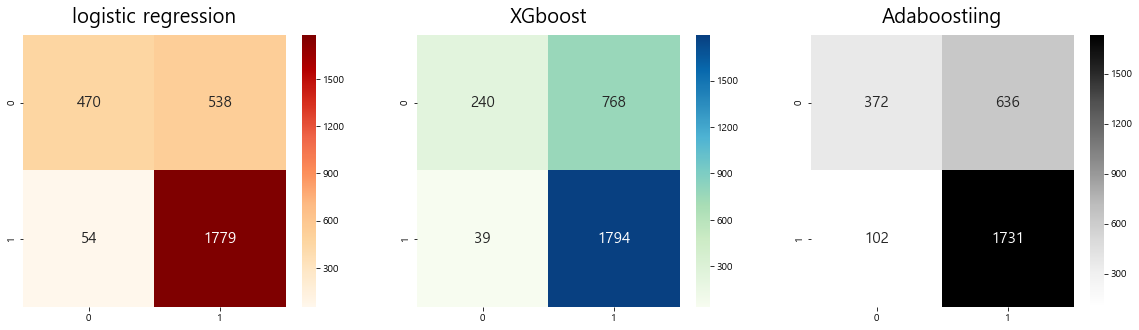

In [42]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = lr_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = XGB_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = AB_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboost',pad = 12, fontsize = 20)
ax[2].set_title('Adaboostiing',pad = 12, fontsize = 20)
plt.show()

### <font color=blue>클래스 불균형 보정 / 모델 재학습</font>

In [43]:
# 긍정리뷰와 부정리뷰의 적절한 균형 보정이 필요하다.
df['y'].value_counts()

1    6234
0    3233
Name: y, dtype: int64

In [44]:
#긍정 리뷰와 부정리뷰에서 각각 부정리뷰 만큼의 무작위 인덱스 값을 추출 하여 랜덤 인덱스 값을 만들고 
# 만들어진 랜덤 인덱스 값을 토데로 각각 X,Y데이터의 균형을 맞춘다.
positive_random_idx = df[df['y']==1].sample(df['y'].value_counts()[0], random_state=0).index.tolist()
negative_random_idx = df[df['y']==0].sample(df['y'].value_counts()[0], random_state=0).index.tolist()

In [45]:
random_idx = positive_random_idx + negative_random_idx
x_data = tf_idf_vect[random_idx]
y_data = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

In [46]:
x_train.shape, y_train.shape

((4526, 22926), (4526,))

#### <font color=blue>LogisticRegression</font>

In [47]:
lr2 = LogisticRegression(random_state = 0)
lr2.fit(x_train, y_train)
lr2_pred = lr2.predict(x_test)

# classification result for test set
print('accuracy: %.2f' % accuracy_score(y_test, lr2_pred))
print('precision: %.2f' % precision_score(y_test, lr2_pred))
print('recall: %.2f' % recall_score(y_test, lr2_pred))
print('F1: %.2f' % f1_score(y_test, lr2_pred))

accuracy: 0.78
precision: 0.77
recall: 0.80
F1: 0.79


#### <font color=blue>Ada-Boosting</font>

In [48]:
AB2 = ensemble.AdaBoostClassifier(random_state=0)
AB2.fit(x_train, y_train)
AB2_pred = AB2.predict(x_test)

print('accuracy: %.2f' % accuracy_score(y_test, AB2_pred))
print('precision: %.2f' % precision_score(y_test, AB2_pred))
print('recall: %.2f' % recall_score(y_test, AB2_pred))
print('F1: %.2f' % f1_score(y_test, AB2_pred))

accuracy: 0.67
precision: 0.62
recall: 0.92
F1: 0.74


#### <font color=blue>XGBoost</font>

In [49]:
from xgboost import XGBClassifier

XGB2 = XGBClassifier(random_state=0)
XGB2.fit(x_train, y_train)
XGB2_pred = XGB2.predict(x_test)
print('accuracy: %.2f' % accuracy_score(y_test, XGB2_pred))
print('precision: %.2f' % precision_score(y_test, XGB2_pred))
print('recall: %.2f' % recall_score(y_test, XGB2_pred))
print('F1: %.2f' % f1_score(y_test, XGB2_pred))

accuracy: 0.69
precision: 0.64
recall: 0.88
F1: 0.74


#### <font color=blue>클래스 보정후 혼동행렬</font>

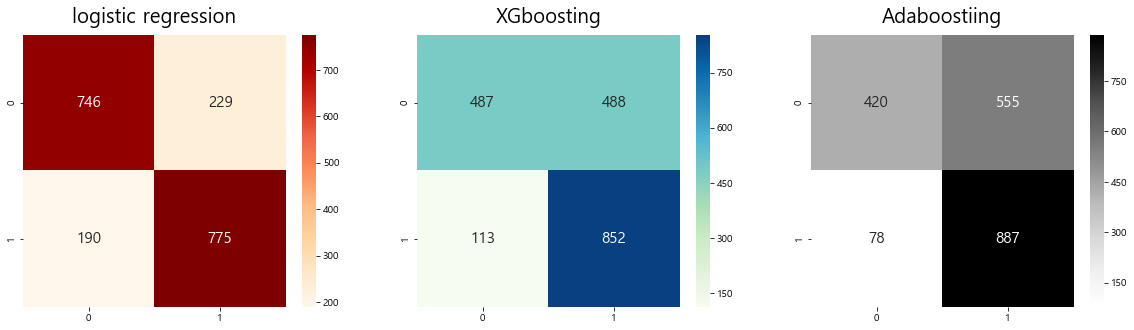

In [50]:
# confusion matrix
from sklearn.metrics import confusion_matrix
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(20, 5))

confu = confusion_matrix(y_true = y_test, y_pred = lr2_pred)
confu2 = confusion_matrix(y_true = y_test, y_pred = XGB2_pred)
confu3 = confusion_matrix(y_true = y_test, y_pred = AB2_pred)


sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g', ax=ax[0])
sns.heatmap(confu2, annot=True, annot_kws={'size':15}, cmap='GnBu', fmt='.10g', ax=ax[1])
sns.heatmap(confu3, annot=True, annot_kws={'size':15}, cmap='Greys', fmt='.10g', ax=ax[2])
ax[0].set_title('logistic regression',pad = 12, fontsize = 20)
ax[1].set_title('XGboosting',pad = 12, fontsize = 20)
ax[2].set_title('Adaboostiing',pad = 12, fontsize = 20)
plt.show()

#### <font color=blue>Grid Search CV (hyper parameter 개선)</font>

In [51]:
from sklearn.model_selection import GridSearchCV

In [52]:
params = {'penalty':['l2','l1'],
'C':list(range(1,10))
}

In [53]:
grid_lr = GridSearchCV(lr2,\
                         param_grid=params , scoring='accuracy' , cv=5)
grid_lr.fit(x_train , y_train)

df_grid_lr = pd.DataFrame(grid_lr.cv_results_)
pd.set_option('display.max.colwidth', 200)
df_grid_lr[['params','mean_test_score','rank_test_score','split0_test_score','split1_test_score','split2_test_score']]\
.sort_values('rank_test_score').head(10)

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'C': 1, 'penalty': 'l2'}",0.786787,1,0.775938,0.798013,0.786976
2,"{'C': 2, 'penalty': 'l2'}",0.785683,2,0.774834,0.803532,0.779249
4,"{'C': 3, 'penalty': 'l2'}",0.784357,3,0.777042,0.793598,0.781457
6,"{'C': 4, 'penalty': 'l2'}",0.783694,4,0.775938,0.794702,0.782561
8,"{'C': 5, 'penalty': 'l2'}",0.783473,5,0.775938,0.794702,0.781457
10,"{'C': 6, 'penalty': 'l2'}",0.782369,6,0.772627,0.796909,0.782561
12,"{'C': 7, 'penalty': 'l2'}",0.782369,6,0.772627,0.796909,0.783664
14,"{'C': 8, 'penalty': 'l2'}",0.781264,8,0.768212,0.794702,0.785872
16,"{'C': 9, 'penalty': 'l2'}",0.781043,9,0.770419,0.793598,0.785872
5,"{'C': 3, 'penalty': 'l1'}",0.759390,10,0.737307,0.762693,0.759382


In [54]:
bestlr = grid_lr.best_estimator_

bestlr_pred = bestlr.predict(x_test)
print('accuracy: %.2f' % accuracy_score(y_test , bestlr_pred))
print('precision: %.2f' % precision_score(y_test, bestlr_pred))
print('recall: %.2f' % recall_score(y_test, bestlr_pred))
print('F1: %.2f' % f1_score(y_test, bestlr_pred))

accuracy: 0.78
precision: 0.77
recall: 0.80
F1: 0.79


#### <font color=blue>ROC Curve</font>

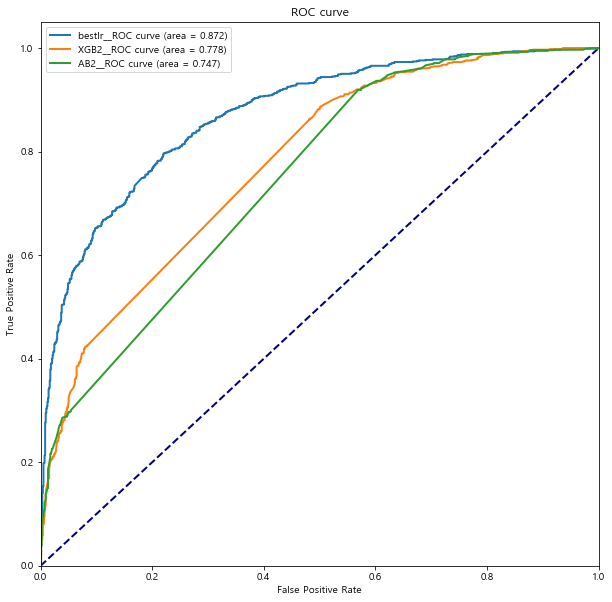

In [55]:
models=[ 'bestlr', 'XGB2', 'AB2']


plt.figure(figsize=(10, 10))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title("ROC curve")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')


# Global 변수 (전역 변수)
# string으로 변수를 설정하고, 값을 할당의 목적으로 사용

for i in models:

    globals()['{}_pred'.format(i)] = \
    globals()['{}'.format(i)].predict_proba(x_test)
    
    globals()['{}_roc'.format(i)]=\
    globals()['{}_pred'.format(i)][:,1]
   
    globals()['fpr_{}'.format(i)],\
    globals()['tpr_{}'.format(i)], \
    globals()['_{}'.format(i)] \
    =roc_curve(y_true=y_test, y_score=globals()['{}_roc'.format(i)]) 
    
    globals()['roc_auc_{}'.format(i)] = \
    auc(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)])
    
    
    
    plt.plot(globals()['fpr_{}'.format(i)], globals()['tpr_{}'.format(i)]
             , lw=2, label=i+'__ROC curve (area = %0.3f)' %globals()['roc_auc_{}'.format(i)])

plt.legend()
plt.show()

In [ ]:
# # print logistic regression's coef

# plt.figure(figsize=(10, 10))
# plt.bar(range(len(lr2.coef_[0])), lr2.coef_[0])

#### <font color=blue>Coefficient & 단어 Mapping</font>

In [56]:
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(3.4765583818638017, 19995), (2.725121454492296, 17508), (2.316609094088273, 1040), (2.2378795415813704, 10052), (1.9851933698633286, 4457)]
[(-2.617779973195562, 13046), (-2.913310374550143, 12935), (-3.2530618919221177, 4251), (-3.4328771237894244, 14421), (-3.530715619898549, 20012)]


In [57]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr2.coef_[0])), reverse = False)

In [58]:
invert_index_vectorizer = {v: k for k, v in vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:1000]+'..')

{17513: '재밌고', 2635: '기대', 14393: '엄청', 17556: '재밌어요', 22644: '후회', 17886: '절대', 21626: '하실', 17552: '재밌어서', 17026: '자막', 14578: '없이', 9647: '보려고', 9676: '보세오', 2464: '그리스', 9151: '배경', 19896: '청량한', 4582: '느낌', 21915: '항상', 15600: '웃고', 16793: '있는', 21175: '표정', 18730: '중독', 1191: '강한', 369: 'ost', 4366: '높은', 20578: '탄탄한', 12151: '스토리', 13162: '아니지만', 22259: '행복해지고', 9587: '보는', 16492: '인생', 11846: '손영주', 18293: '좋네요', 20054: '추천', 14762: '역시', 12523: '실망', 12366: '시키지', 13687: '않았음', 1163: '강렬해서', 6311: '들을', 7006: '마다', 855: '가슴', 2080: '괜히', 8489: '뭉클해져', 17140: '잔인하네', 12876: '쏘우', 17856: '전작', 9977: '봐서', 4870: '다행', 2335: '그것', 8931: '밖에는', 16453: '인간', 20602: '탐욕', 16058: '이기심', 17754: '적나라하게', 6085: '드러낸', 7952: '명작', 21731: '한국영', 17090: '자체', 18141: '조우진', 22232: '했음', 9603: '보는내내', 2787: '긴장감', 16887: '있었어요', 19110: '진기', 5248: '대박', 7074: '마지막', 16356: '이었음', 18638: '죽을지', 8119: '몰라야', 10906: '사는게', 17540: '재밌다는게', 15685: '원작', 2346: '그대로', 6417: '따라하고', 11213: '삼성', 1957

In [59]:
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최고 3.4765583818638017
재밌게 2.725121454492296
감동 2.316609094088273
봤습니다 2.2378795415813704
눈물 1.9851933698633286
사랑 1.9682670504034105
좋고 1.9596549601956468
봤어요 1.893216103305873
재밌었어요 1.8688821857292444
나름 1.8150919139952852
재밌음 1.8030834850762154
좋았어요 1.7984684027925226
몰입 1.7548131070972417
대박 1.7416441792235235
긴장감 1.6370650970295515
재밌었다 1.5909169448909992
엠마 1.5476254313661897
존잼 1.544901283059899
소름 1.5379722968199263
실화 1.536312011730894


In [60]:
for coef in coef_neg_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최악 -3.530715619898549
없고 -3.4328771237894244
노잼 -3.2530618919221177
쓰레기 -2.913310374550143
아깝다 -2.617779973195562
보다가 -2.242543511905399
예고편 -2.238752956615101
개연 -2.05617162948533
아까 -1.9505778710181392
낭비 -1.8379719218631025
스토리 -1.8185703128139754
경찰 -1.7793216527832976
수준 -1.7469952840653737
광고 -1.738315147484867
설정 -1.6756772380327156
재미없는 -1.6698033249045237
알바 -1.6344567083752428
라고 -1.600881341247055
내용 -1.5965231716058474
재미없음 -1.5800828924158825


# <font color=#cccccc>입력 TEXT에 대한 감정 예측</font>

In [61]:
df_word_and_numb = pd.DataFrame(list(vect.vocabulary_.items()), columns=['word','word_num'])
df_score_and_numb = pd.DataFrame(coef_pos_index,columns=['score','word_num'])
df_final = pd.merge(df_word_and_numb, df_score_and_numb ,how = 'inner', on = 'word_num')
df_final

,word,word_num,score
0,재밌고,17513,1.039759
1,기대,2635,1.221022
2,엄청,14393,0.721163
3,재밌어요,17556,1.488000
4,후회,22644,0.136363
5,절대,17886,-0.497874
6,하실,21626,0.000000
7,재밌어서,17552,0.782765
8,자막,17026,0.355043
9,없이,14578,0.800071


In [ ]:
# input되는 string을 점수로 바꿔주는 작업
test_text = str(input("리뷰를 달아주세요 (예시: 정말 재미있었어요!): "))
okt.pos(test_text, norm=True, stem=True)
clnd_txt = text_cleaning(test_text)


# 점수 계산기
sum_of_coef = 0
count_of_sum = 0
for text in clnd_txt:
    if text in list(df_final['word']):
        sum_of_coef += float(df_final[df_final['word']==text]['score'])
        count_of_sum += 1

        
# 긍정, 부정 판독기
if count_of_sum != 0:
    final_score = sum_of_coef/count_of_sum
    print(final_score)
    if final_score >0.1:
        print('영화가 좋았군요!')
    elif final_score <-0.1 :
        print('영화가 취향에 맞지 않으셨군요ㅠㅠ')
    else :
        print('그저그러셨군요!')
else :
    print("무슨 말씀인지 이해하지 못했어요.")